In [87]:
import pandas as pd
from pandas import read_csv
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

In [89]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
data = pd.read_csv('air_visit_data.csv', parse_dates=['visit_date'], index_col='visit_date',date_parser=dateparse)
data.head()


,visitors
visit_date,
2016-01-13,25
2016-01-14,32
2016-01-15,29
2016-01-16,22
2016-01-18,6


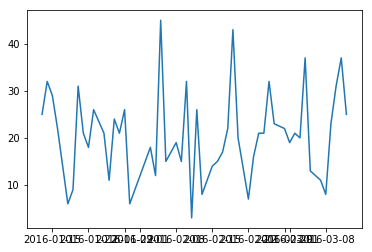

In [93]:
plt.plot(data[0:50])
plt.show()

In [102]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=100).mean()
    rolstd = timeseries.rolling(window=100).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

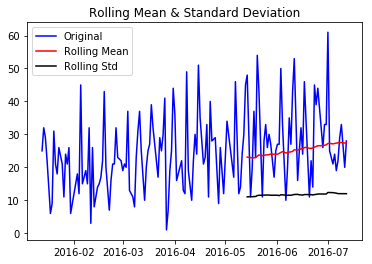

In [105]:
test_stationarity(data[0:150])

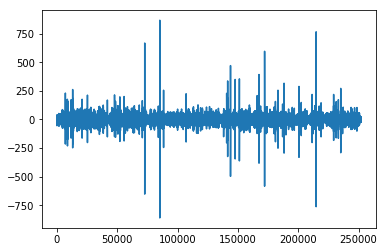

In [107]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["visitors"][i] - dataset["visitors"][i - interval]
        diff.append(value)
    return (diff)


diff = difference(data)
plt.plot(diff)
plt.show()

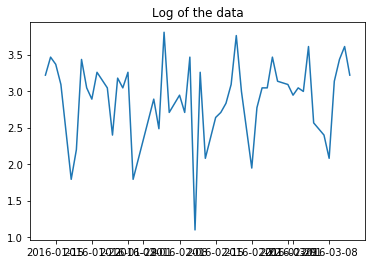

In [109]:
ts_log = np.log(data)
plt.title('Log of the data')
plt.plot(ts_log[0:50])
plt.show()

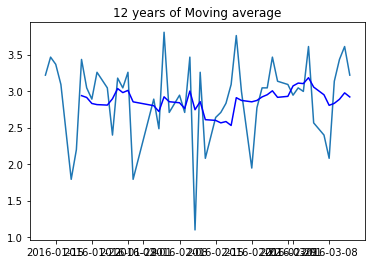

In [112]:
moving_avg = ts_log.rolling(7).mean()
plt.plot(ts_log[0:50])
plt.title('12 years of Moving average')
plt.plot(moving_avg[0:50], color='blue')
plt.show()

In [113]:
ts_log_moving_avg_diff = ts_log - moving_avg

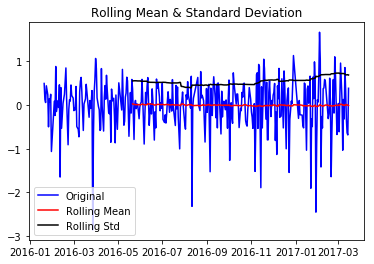

In [117]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff[0:350])

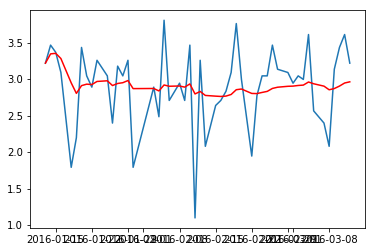

In [119]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
#parameter halflife is used to define the amount of exponential decay
plt.plot(ts_log[0:50])
plt.plot(expwighted_avg[0:50], color='red')
plt.show()

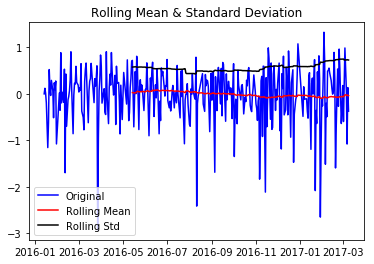

In [123]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff[0:350])

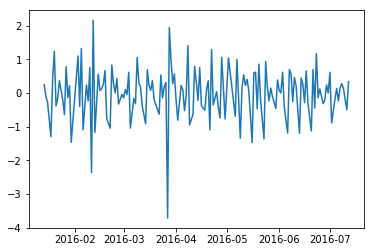

In [124]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff[0:150])
plt.show()

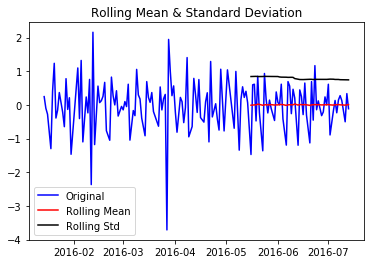

In [126]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff[0:150])

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

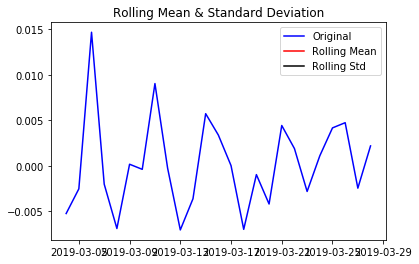

In [128]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

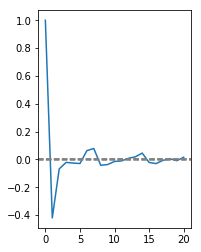

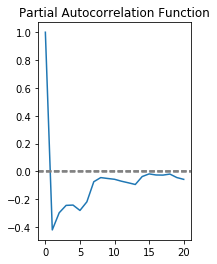

<Figure size 432x288 with 0 Axes>

In [129]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

C:\Users\subhadip_jot\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\subhadip_jot\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


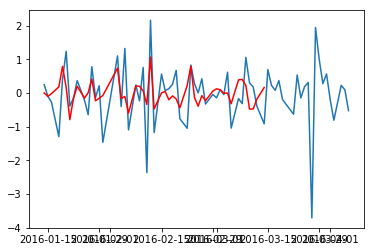

In [133]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0), freq=ts_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff[0:70])
plt.plot(results_AR.fittedvalues[0:50], color='red')
plt.show()

C:\Users\subhadip_jot\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\subhadip_jot\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


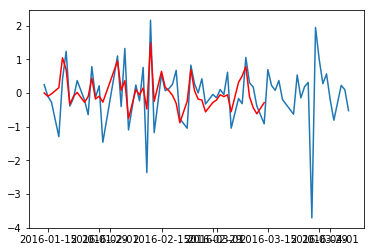

In [134]:
model = ARIMA(ts_log, order=(2, 1, 2), freq=ts_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff[0:70])
plt.plot(results_ARIMA.fittedvalues[0:50], color='red')
plt.show()